In [7]:
import cml

vodafone_data = cml.VodafoneData()
vodafone_roads_df = vodafone_data.read('data/vodafone_main_roads/')
vodafone_data.preprocess(vodafone_roads_df)
columns = ['Grid_ID', 'Datetime', 'C1', 'C2', 'C5', 'C6', 'C11', 'E1', 'E7', 'E8', 'E9']
vodafone_roads_df = vodafone_roads_df[columns]
print(vodafone_roads_df.shape)
vodafone_roads_df.head()

(14501312, 11)


,Grid_ID,Datetime,C1,C2,C5,C6,C11,E1,E7,E8,E9
0,16,2022-09-01 00:00:00+00:00,4.66,0.00,0.00,21.139999,0.0,0.0,5.0,5.00,5.0
1,16,2022-09-01 00:05:00+00:00,9.55,1.81,4.73,36.939999,0.0,0.0,0.0,1.25,5.0
2,16,2022-09-01 00:10:00+00:00,11.66,0.00,6.85,17.750000,0.0,0.0,0.0,5.17,31.0
3,16,2022-09-01 00:15:00+00:00,15.79,1.78,11.05,19.740000,0.0,0.0,0.0,4.25,29.0
4,16,2022-09-01 00:20:00+00:00,10.59,0.00,5.81,26.629999,0.0,0.0,0.0,5.92,43.0


In [8]:
vodafone_roads_df.set_index('Datetime', inplace=True)
vodafone_roads_df = vodafone_roads_df.groupby('Grid_ID', observed=False).resample('60T').mean()
vodafone_roads_df.drop(columns=['Grid_ID'], inplace=True)
vodafone_roads_df.reset_index(inplace=True)
vodafone_roads_df.dropna(inplace=True)

vodafone_roads_df.head()

,Grid_ID,Datetime,C1,C2,C5,C6,C11,E1,E7,E8,E9
0,16,2022-05-01 00:00:00+00:00,12.656667,0.0000,3.790000,2.799167,0.0,0.0,1.666667,6.970000,20.666667
1,16,2022-05-01 01:00:00+00:00,16.698333,0.0000,3.143333,4.082500,0.0,0.0,1.750000,7.672500,20.583333
2,16,2022-05-01 02:00:00+00:00,15.377500,0.0000,1.968333,4.072500,0.0,0.0,0.166667,22.867500,132.250000
3,16,2022-05-01 03:00:00+00:00,12.857500,0.1375,1.461667,6.820000,0.0,0.0,0.500000,65.028333,300.000000
4,16,2022-05-01 04:00:00+00:00,11.298333,0.0000,2.725833,8.641667,0.0,0.0,0.000000,29.980833,300.000000


In [9]:
import pandas as pd
import tqdm

from sklearn.preprocessing import MinMaxScaler

vodafone_roads_df.drop(columns=['C2', 'E7', 'E9'], inplace=True)
vodafone_roads_df['day_of_week'] = vodafone_roads_df['Datetime'].dt.day_of_week
vodafone_roads_df['hour'] = vodafone_roads_df['Datetime'].dt.hour
vodafone_roads_df.loc[vodafone_roads_df['C11'] < 10, 'C11'] = 0.0
vodafone_roads_df.drop(columns=['Datetime'], inplace=True)
vodafone_roads_df.replace(0, 1, inplace=True)
vodafone_roads_df = vodafone_roads_df.groupby(['Grid_ID', 'day_of_week', 'hour'], observed=False).transform(lambda x: x / x.mean())
vodafone_roads_df.dropna(inplace=True)

scaler = MinMaxScaler()
scaler.fit(vodafone_roads_df)
scaled = scaler.transform(vodafone_roads_df)
scaled_df = pd.DataFrame(scaled, columns=vodafone_roads_df.columns)

In [10]:
import numpy as np

from minisom import MiniSom

som_sizes = [10, 15, 20, 25]
learning_rates = [1.0, 2.0, 2.5, 3.0]
sigmas = [1.0, 2.0, 3.0, 4.0]

best_params = None
best_som = None
best_score = np.inf

scores = np.zeros((len(som_sizes), len(learning_rates), len(sigmas)))
pbar = tqdm.tqdm(total=len(som_sizes)*len(learning_rates)*len(sigmas))

for i, size in enumerate(som_sizes):
    for j, rate in enumerate(learning_rates):
        for k, sigma in enumerate(sigmas):
            som = MiniSom(size, size, len(scaled_df.columns), sigma=sigma, learning_rate=rate, random_seed=42)
            som.train(scaled_df.values, 200, random_order=False, verbose=False)
            
            score = som.quantization_error(scaled_df.values)
            scores[i, j, k] = score
            
            if score < best_score:
                best_score = score
                best_som = som
                best_params = {'size': size, 'learning_rate': rate, 'sigma': sigma}
            
            pbar.update(1)

pbar.close()
print('Best parameters: ', best_params)
print('Best score: ', best_score)

100%|██████████| 64/64 [05:49<00:00,  5.47s/it]

Best parameters:  {'size': 20, 'learning_rate': 3.0, 'sigma': 2.0}
Best score:  0.026810606461424597


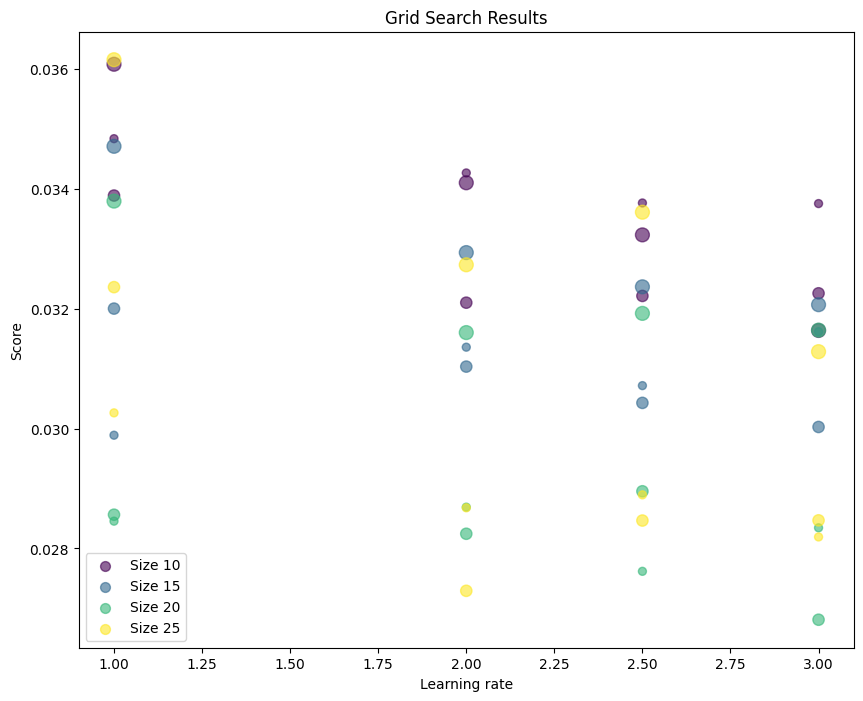

In [19]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Flatten the scores and parameters for the scatter plot
flat_scores = scores.flatten()
flat_sizes = np.repeat(som_sizes, len(learning_rates)*len(sigmas))
flat_rates = np.tile(np.repeat(learning_rates, len(sigmas)), len(som_sizes))
flat_sigmas = np.tile(sigmas, len(som_sizes)*len(learning_rates))

# Normalize the scores to the range [0, 1] for the size mapping
normalized_sigmas = (flat_sigmas - flat_sigmas.min()) / (flat_sigmas.max() - flat_sigmas.min())

# Create a colormap for the sizes
colors = cm.viridis(np.linspace(0, 1, len(som_sizes)))

# Create the scatter plot
plt.figure(figsize=(10, 8))
for i, size in enumerate(som_sizes):
    idx = flat_sizes == size
    plt.scatter(flat_rates[idx], flat_scores[idx], c=[colors[i]], s=100*(1-normalized_sigmas[idx]), label=f'Size {size}', alpha=0.6)

# Add labels, title, and legend
plt.xlabel('Learning rate')
plt.ylabel('Score')
plt.title('Grid Search Results')
plt.legend()

plt.show()

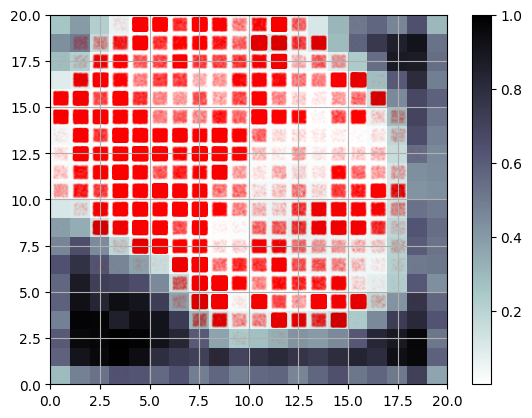

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def get_neurons(som, df):
    w_x, w_y = zip(*[som.winner(d) for d in df.values])
    w_x = np.array(w_x)
    w_y = np.array(w_y)

    return w_x, w_y


def plot_distance_map(df, som, mark_size=1, alpha=1):
    plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=1)
    plt.colorbar()
    w_x, w_y = get_neurons(som, df)
    plt.scatter(w_x + .5 + (np.random.rand(len(w_x)) - .5) * .7, 
                w_y + .5 + (np.random.rand(len(w_y)) - .5) * .7, 
                s=mark_size, color='r', alpha=alpha)

    plt.grid()
    plt.show()

plot_distance_map(scaled_df, best_som, alpha=.01)

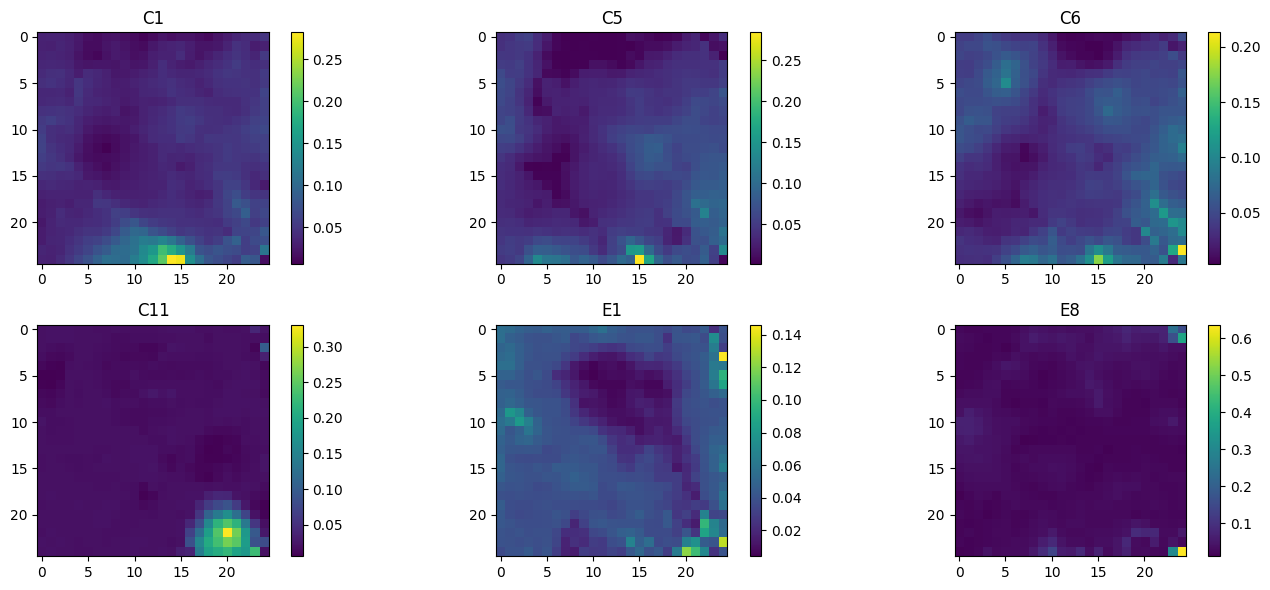

In [17]:
def plot_features_map(df, som):
    w_x, w_y = get_neurons(som, df)
    df['w_x'] = w_x
    df['w_y'] = w_y
    grouped_df = df.groupby(['w_x', 'w_y']).mean()

    fig, axes = plt.subplots(2, 3, figsize=(14, 6))
    for ax, col in zip(axes.flat, grouped_df.columns):
        ax.set_title(col)
        col_pivot = grouped_df[[col]].pivot_table(index='w_x', columns='w_y')
        col_pivot.fillna(0, inplace=True)
        im = ax.imshow(col_pivot.to_numpy().T)
        plt.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()
    df.drop(columns=['w_x', 'w_y'], inplace=True)

plot_features_map(scaled_df, som)

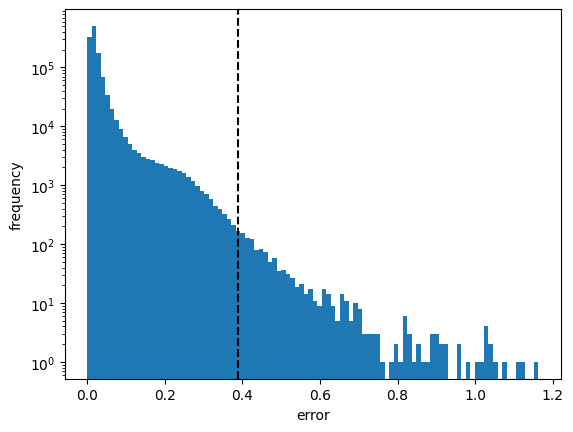

In [14]:
outliers_percentage = 0.001
quantization_errors = np.linalg.norm(som.quantization(scaled_df.values) - scaled_df.values, axis=1)
error_threshold = np.percentile(quantization_errors, 
                               100*(1 - outliers_percentage))
plt.hist(quantization_errors, bins=100)
plt.axvline(error_threshold, color='k', linestyle='--')
plt.xlabel('error')
plt.ylabel('frequency')
plt.yscale('log')
plt.show()

(1211, 6)
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.13605026261924877


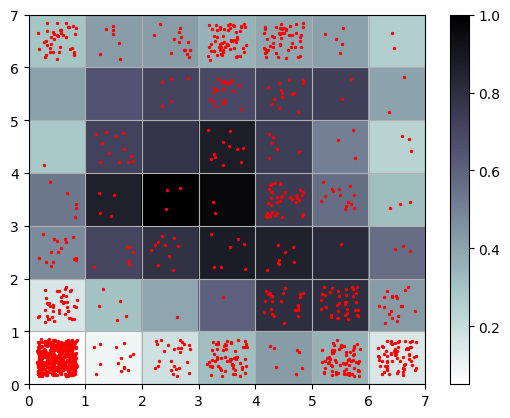

In [15]:
som_size = 7
outliers_df = scaled_df[quantization_errors > error_threshold].copy()
print(outliers_df.shape)
som_outliers = MiniSom(som_size, som_size, len(outliers_df.columns), sigma=3, learning_rate=1, random_seed=42)
som_outliers.train(outliers_df.values, 1000, random_order=False, verbose=True)

plot_distance_map(outliers_df, som_outliers, mark_size=2, alpha=1)

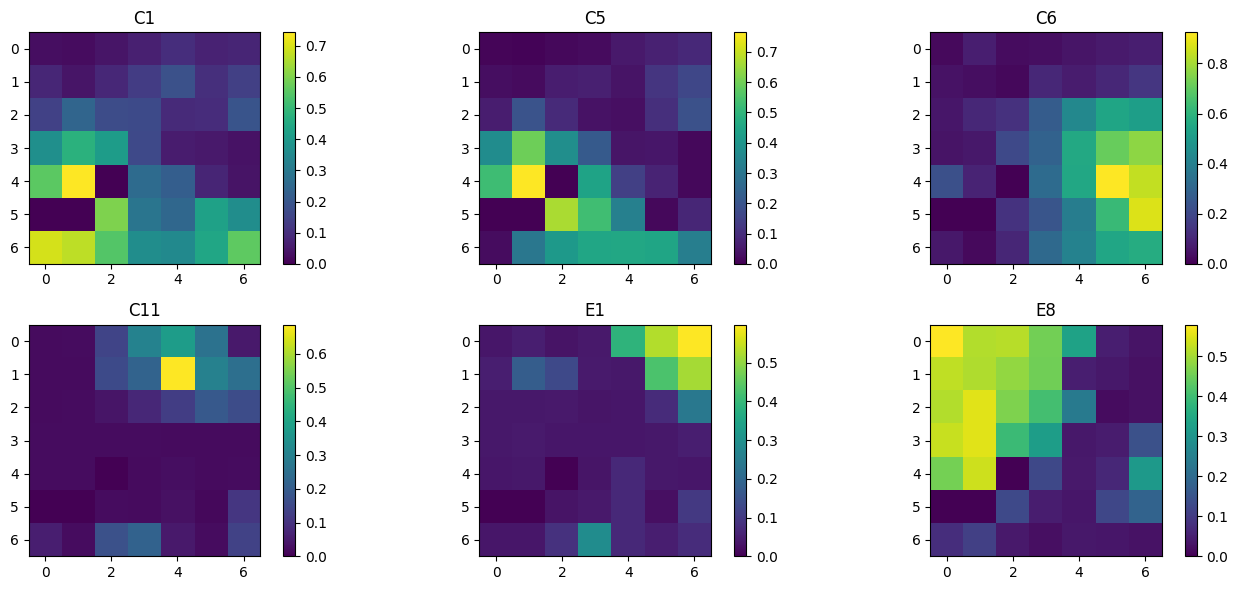

In [18]:
plot_features_map(outliers_df, som_outliers)